# STAT 207 Final Project - Game Revenue Analysis


### Vedaant Agarwal, Spencer Bauer, Reece Farrell, Jay Yang

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

## 1. Introduction

### 1.1 Primary Research Goal of Analysis

The primary research goal of this project is to build a predictive model that will perform the best when predicting the review score (high or low) of a game in new datasets.

### 1.2 Interpretive Secondary Research Goal of Analysis

Ideally, we would like for our chosen model to also yield reliable interpretative insights
about the nature of the relationship between the variables in the dataset.

### 1.3 Descriptive Secondary Research Goal of Analysis

The variables used in this study should be throughouly described, both individually as well as in their relation with the other variables and the response. This should be done in the context of the primary research goal.

### 1.4. Research Introduction and Motivation

The prediction of how good a game would be is something that could be very helpful for game production companies as they would try and incorporate features that make their games better. Predicting whether a game would get a high or low review score would help to that end. It could also help companies that give out game ratings like IGN, etc to get a baseline rating that could be helpful in their critics score. This would also give a way for people who purchase a game to get a feeling of whether a game would be good or bad before actual ratings are released.

Studies like this have already been perfomed. In Reference[1], the sales data for the games were analysed to try and figure out what makes a game good. Similarly, in Reference[2], a video game sales dataset was analysed to figure out trends based on country to country sales.

A desirable classifier for this case would be something equally high accuracy for both "positives" and "negatives" as a critic would not want to classify a bad game as a good game or vice versa. So equally high accuracy is preferred as there is no weightage. The same could be said for game production companies, they would like to know if a game is bad, and if a game is good, both equally.

## 2. Dataset Discussion

### 2.1 Dataset Display

In [2]:
games = pd.read_csv('video_games.csv')
games.head()

,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,...,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,...,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


In [3]:
games.shape[0]

1212

The original dataframe has 1212 columns.

### 2.2 Dataset Source and Information

Originally collected by Dr. Joe Cox, this dataset has information about the sales and playtime of over a thousand video games released between 2004 and 2010. Each row in the dataframe represents a unique video game released between 2004 and 2010. The playtime information was collected from crowd-sourced data on “How Long to Beat”. Some more information can be found on: https://researchportal.port.ac.uk/en/publications/what-makes-a-blockbuster-video-game-an-empirical-analysis-of-us-s

The dataset might not be inclusive of all games released between 2004 and 2010 as there were some indie game publishers that are not listed in the dataset, so their games are not represented. This makes it so that this analysis is primarily focused towards the big game publishing companies, and any inferences taken from ths study should also be limited to those companies.

Similarly, only the major consoles were considered, and games released on other consoles were not included. Again, any inferences made should be within the scope of these consoles.

This is the sample dataset that was provided in the project. The dataset was downloaded by Dr. Ellison on 9/8/2023 from: https://corgis-edu.github.io/corgis/csv/video_games/

### 2.3 Selected Variables

The response variable for this study will be `Metrics.Review Score`, which is a typical review score for the games, out of 100. However, since a binary response variable must be chosen, a transformation will be applied to `Metrics.Review Score` to seperate it into two levels of "high" and "low" scores. The specifics for this transformation will be discussed in the coming section.

The explanatory variables that the full model will start of with are chosen to be:

1. `Features.Max Players`: The maximum number of players that can play this game.
2. `Metrics.Sales` : The total sales made on this game, measured in millions of dollars.
3. `Metrics.Used Price` : A typical "used" price for this game (i.e. previously returned and sold), measured in dollars. It is unclear where this number originally came from.
4. `Release.Year` : The year that this game was released.
5. `Length.All PlayStyles.Median` : The median time that players reported completing the game in any way, in hours. This is the median over all the other categories.
6. `Release.Rating` : The ESRB rating for this game, either E (for Everyone), T (for Teen), or M (for Mature).
7. `Release.Console` : The name of the console that this particular game was released for. Note that the dataset contains multiple copies of the same game, released for different consoles.

The explanatory variables mentioned above were chosen to be focused on because heuristically, out of all available explanatory variables in the dataset, these would make the most sense to naturally have a relation with the review score of a game. Moreover, the dataset includes game length for various playstyles, and the chosen variable `Length.All PlayStyles.Median` is the median over all types of players, so it would be more representative of the entire population.

## 3. Dataset Cleaning

Firstly, a new dataframe will be made which includes only the columns corresponding to the previously mentioned explanatory variables and the response variable.

In [4]:
games_new = games[['Metrics.Review Score', 'Features.Max Players', 'Metrics.Sales', 'Metrics.Used Price',
                   'Release.Year', 'Length.All PlayStyles.Median', 'Release.Rating', 'Release.Console']]

### 3.1 Implicit Missing Values and NA Removal

Now, the filtered dataframe will be checked for any implicit missing values. 

In [5]:
games_new.dtypes

Metrics.Review Score              int64
Features.Max Players              int64
Metrics.Sales                   float64
Metrics.Used Price              float64
Release.Year                      int64
Length.All PlayStyles.Median    float64
Release.Rating                   object
Release.Console                  object
dtype: object

All of the variables have the expected data type designation. The categorical variables will now be checked to see if there are any strings that are expressing a missing value.

In [6]:
games_new['Release.Rating'].unique()

array(['E', 'M', 'T'], dtype=object)

In [7]:
games_new['Release.Console'].unique()

array(['Nintendo DS', 'Sony PSP', 'X360', 'Nintendo Wii', 'PlayStation 3'],
      dtype=object)

As seen from the output above, the categorical columns do not seem to have any implicit missing value. Now any `NaN` values in the dataframe can be dropped.

In [8]:
games_new.isna().sum()

Metrics.Review Score            0
Features.Max Players            0
Metrics.Sales                   0
Metrics.Used Price              0
Release.Year                    0
Length.All PlayStyles.Median    0
Release.Rating                  0
Release.Console                 0
dtype: int64

There are no `NaN` values, so the dataset is now cleaned from missing values.

### 3.2 Sample Size Cleaning

The categorical variables should be checked to see if some levels have low counts compared to the other levels, and should either be assimilated into a common group or dropped to avoid overfitting.

In [9]:
games_new['Release.Rating'].value_counts()

Release.Rating
E    491
T    470
M    251
Name: count, dtype: int64

In [10]:
games_new['Release.Console'].value_counts()

Release.Console
Nintendo DS      317
X360             287
Sony PSP         242
Nintendo Wii     187
PlayStation 3    179
Name: count, dtype: int64

As seen above, for the two chosen categorical variable `Release.Rating` and `Release.Console`, every corresponding level has a comparable frequency, so dropping or grouping levels is not needed for now.

### 3.3 Outlier Cleaning - Two Variable Outlier Inspection

/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


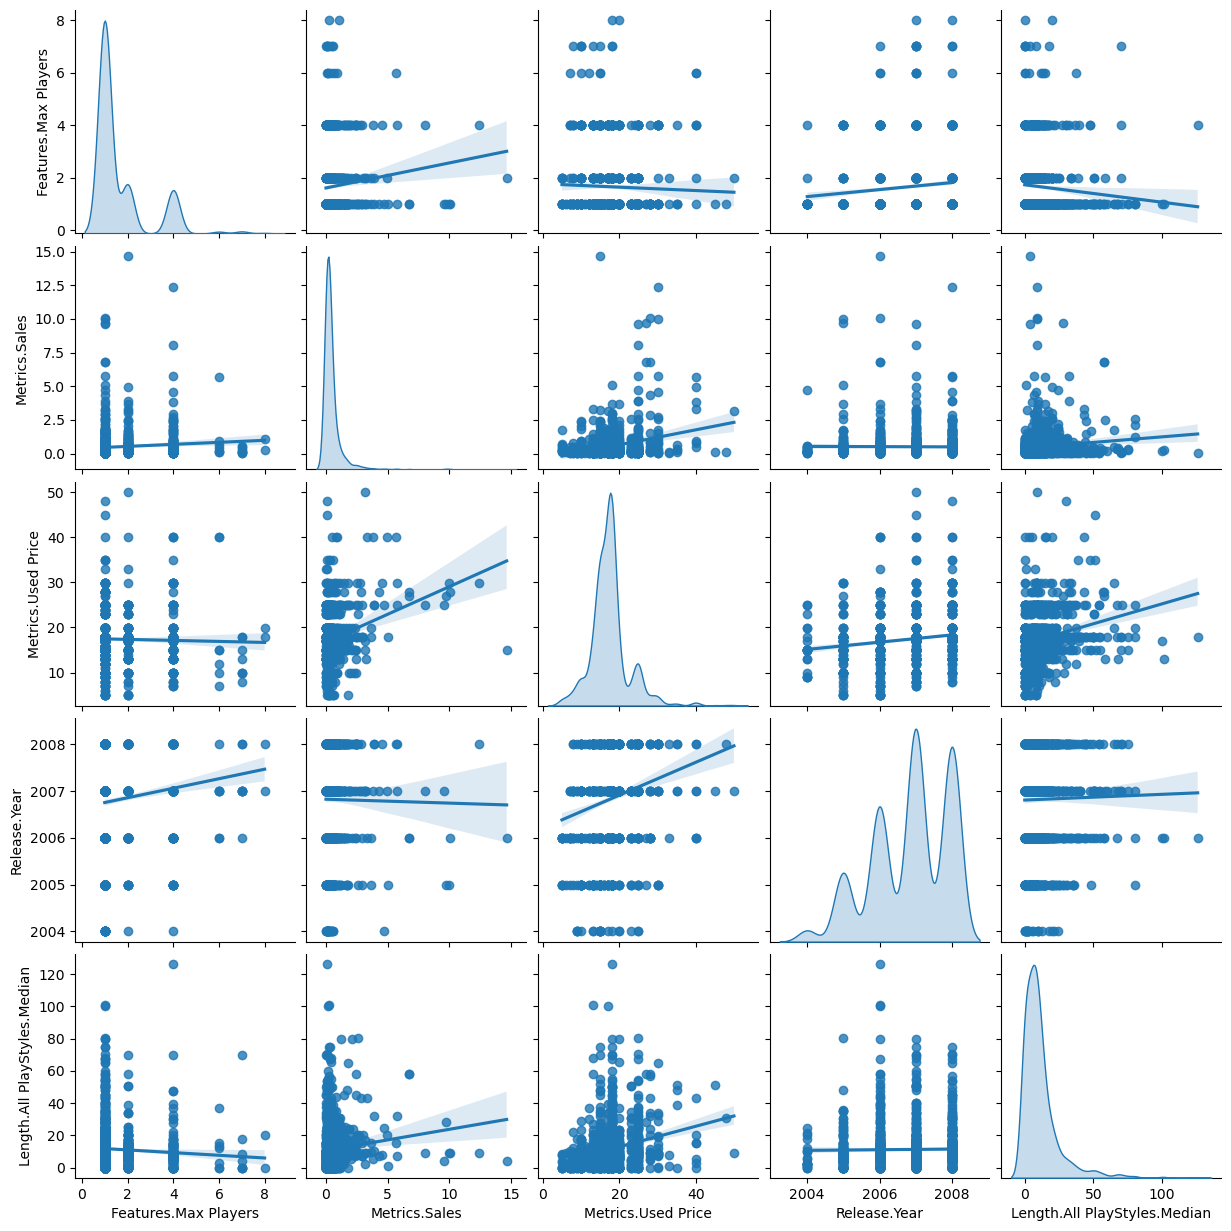

In [11]:
num_var = ['Features.Max Players', 'Metrics.Sales', 'Metrics.Used Price', 'Release.Year',
           'Length.All PlayStyles.Median']

sns.pairplot(games_new[num_var], kind="reg", diag_kind="kde")
plt.show()

It is evident from the scatterplots above that outliers do exist in the pairwise numerical relations. Even if the outliers of the ordinal variables `Release.Year` and `Features.Max Players` are ignored, since these are practically numerical levels and can be treated as categorical variables, the true numerical variables still do have outliers.

In [12]:
outliers = {}
for i in games_new[num_var]:
    outliers[i] = []
    mean = games_new[i].mean()
    std = games_new[i].std()
    for j in games_new[i].index:
        z_score = (games_new[i][j] - mean) / std
        if np.abs(z_score) > 3:
            outliers[i].append(j)

for i in outliers.keys():
    print(i, len(outliers[i]))

Features.Max Players 17
Metrics.Sales 20
Metrics.Used Price 16
Release.Year 0
Length.All PlayStyles.Median 28


As seen in the distribution of the variables themselves, outliers are present. For now, it is chosen to remove the outliers in the distribution of `Metrics.Sales` since it is expected that this variable would be the most influential in prediction.  Taking a look at what values of `Metrics.Sales` are classified as outliers:

In [13]:
games_new["Metrics.Sales"][outliers["Metrics.Sales"]].values

array([ 4.69,  9.99,  9.72,  5.07, 14.66, 10.03,  6.77,  6.77,  9.6 ,
        8.03,  5.77,  4.94,  4.34,  3.84, 12.39,  5.76,  5.71,  4.58,
        3.91,  3.9 ])

In [14]:
games_new["Metrics.Sales"].median()

0.21

It can be seen that all these outliers are high outliers. Therefore, the con of dropping these outliers is that the model would not be representative of games with high sales, and consequently might give poor results for these cases. However, the pro of removing these outliers is that it prevents the model from getting heavily skewed by these influential points, which might lead to overfitting and bad predictions for the entire dataset. 

Now, these outliers are dropped.

In [15]:
games_out = games_new.drop(outliers["Metrics.Sales"])

games_out.shape[0]

1192

In [16]:
games_new.shape[0] - games_out.shape[0]

20

As expected, 20 rows are dropped.

/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


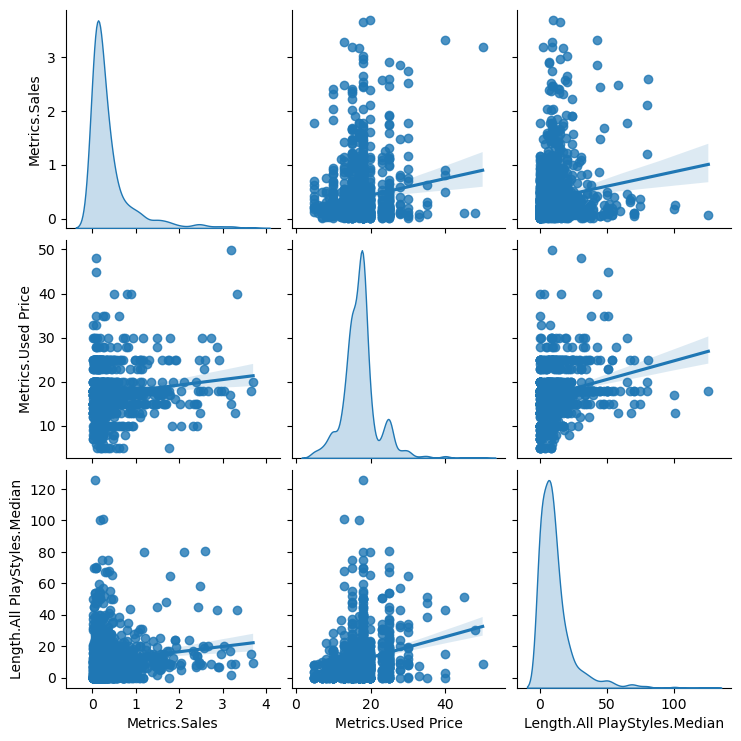

In [17]:
num_var2 = ['Metrics.Sales', 'Metrics.Used Price', 'Length.All PlayStyles.Median']

sns.pairplot(games_out[num_var2], kind="reg", diag_kind="kde")
plt.show()

For the sake of a cleaner plot the two ordinal variables were excluded from the pairplot above. As can be noted, there still appear to be outliers, but there is a noticeble improvement in the spread from the plots before.

### 3.4 Other Data Cleaning

Now the previously mentioned transformation of the response variable `Metrics.Review Score` can be done. Rather than selecting an arbitrary cutoff for categorizing a score as high or low, the median score is chosen as the cutoff so as to better adhere to the distribution of `Metrics.Review Score` in the dataset.

In [18]:
score = games_out['Metrics.Review Score'] 
games_out['Review_Score_Binary'] = np.where(score < score.median(), 'Low', 'High')

In [19]:
games_out.head()

,Metrics.Review Score,Features.Max Players,Metrics.Sales,Metrics.Used Price,Release.Year,Length.All PlayStyles.Median,Release.Rating,Release.Console,Review_Score_Binary
1,89,1,0.56,14.95,2004,10.0,E,Sony PSP,High
2,81,2,0.54,22.95,2004,2.5,E,Nintendo DS,High
3,81,1,0.49,12.95,2004,0.0,E,Sony PSP,High
4,61,1,0.45,14.95,2004,10.0,E,Nintendo DS,Low
5,67,1,0.41,12.95,2004,20.0,M,Nintendo DS,Low


In [20]:
games_out.columns

Index(['Metrics.Review Score', 'Features.Max Players', 'Metrics.Sales',
       'Metrics.Used Price', 'Release.Year', 'Length.All PlayStyles.Median',
       'Release.Rating', 'Release.Console', 'Review_Score_Binary'],
      dtype='object')

The column names include whitespaces and special characters that would cause issues in function calls later on. It is best to rename them now. Also, the original column containing the numerical values of the review score can be dropped now.

In [21]:
games_drop = games_out.drop(['Metrics.Review Score'], axis = 1)
games_final = games_drop.rename(columns={'Features.Max Players':'max_players', 'Metrics.Sales':'sales',
                                         'Metrics.Used Price':'used_price', 'Release.Year':'year',
                                         'Length.All PlayStyles.Median':'median_length',
                                         'Release.Rating':'rating', 'Release.Console':'console',
                                         'Review_Score_Binary':'review_score_binary'})
games_final.head()

,max_players,sales,used_price,year,median_length,rating,console,review_score_binary
1,1,0.56,14.95,2004,10.0,E,Sony PSP,High
2,2,0.54,22.95,2004,2.5,E,Nintendo DS,High
3,1,0.49,12.95,2004,0.0,E,Sony PSP,High
4,1,0.45,14.95,2004,10.0,E,Nintendo DS,Low
5,1,0.41,12.95,2004,20.0,M,Nintendo DS,Low


This will be the final cleaned dataset that will be used for the rest of the analysis.

## 4. Preliminary Analysis

### 4.1 Relationships between the Response Variable and the Explanatory Variables

Looking at the relationships between the numerical explanatory variables and the response variable :

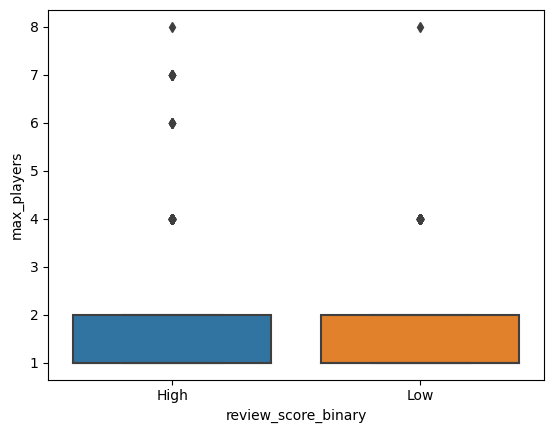

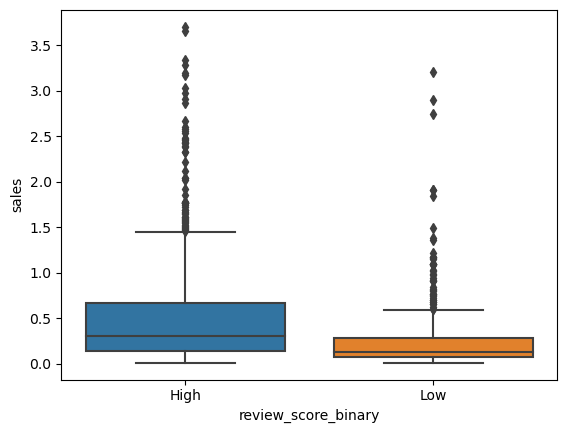

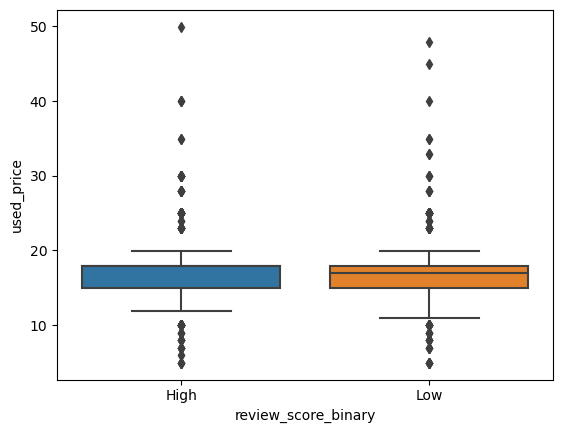

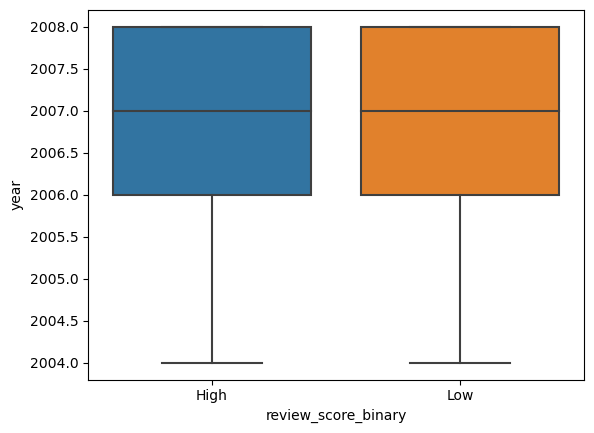

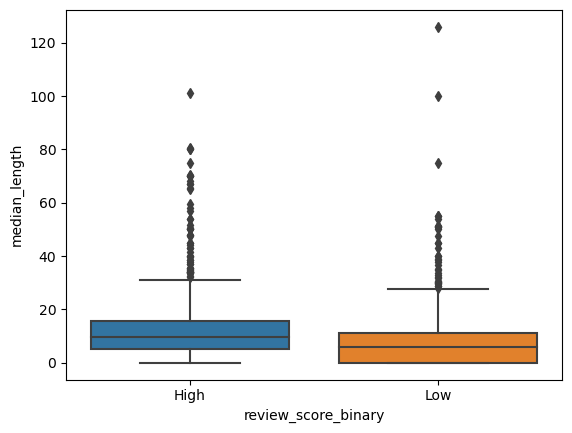

In [22]:
num = ['max_players', 'sales', 'used_price', 'year', 'median_length']

for i in num:
    sns.boxplot(x = 'review_score_binary', y = i, data = games_final)
    plt.show()

As seen in the plots above, out of the selected numerical variables, `median_length` and `sales` have the strongest association with the response. On the other hand, `max_players` and `year` have the weakest (as far as zero) association with the response, as evidenced by the boxes having a perfect overlap.

Moving on to check for the assocation of the categorical explanatory variables with the response:

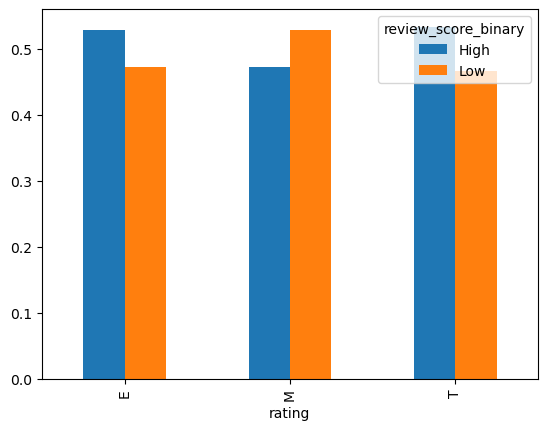

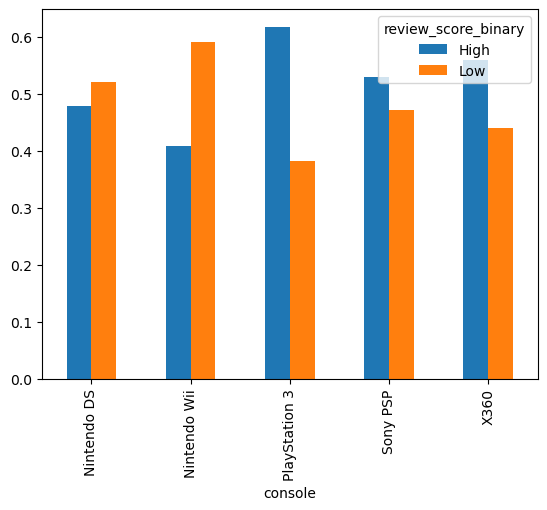

In [23]:
cat = ['rating', 'console']
for i in cat:
    temp = pd.crosstab(games_final[i], games_final['review_score_binary'], normalize='index')
    temp.plot.bar()
    plt.show()

As seen by the barplots above, both `console` and `rating` do have an association with the response, however, `console` has a stronger association as seen by the same colored bars being a lot more different than that for `rating`.

### 4.2 Relationships between Explanatory Variable Pairs

First, scatterplots between numerical explanatory variable pairs will be examined.

/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


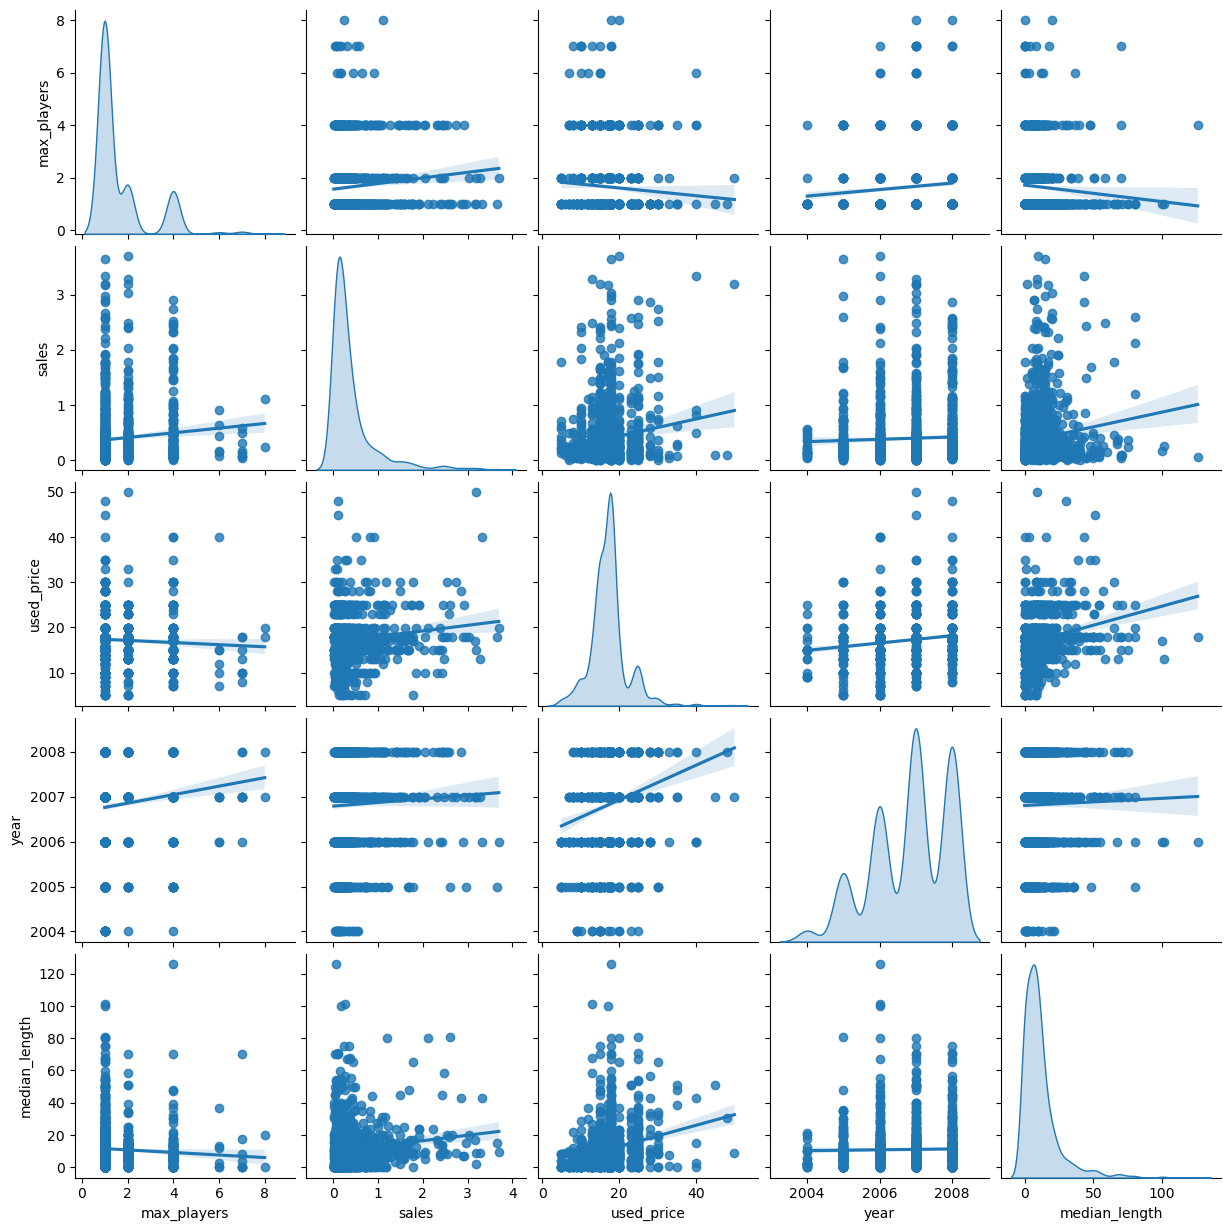

In [24]:
num = ['max_players', 'sales', 'used_price', 'year', 'median_length']
sns.pairplot(games_final[num], kind="reg", diag_kind="kde")
plt.show()

In [25]:
games_final[num].corr()

,max_players,sales,used_price,year,median_length
max_players,1.000000,0.095125,-0.058926,0.107945,-0.070498
sales,0.095125,1.000000,0.138781,0.041141,0.134403
used_price,-0.058926,0.138781,1.000000,0.176794,0.235281
year,0.107945,0.041141,0.176794,1.000000,0.020332
median_length,-0.070498,0.134403,0.235281,0.020332,1.000000


As seen in the pairplot, as well as the correlation matrix, there does not seem to be any high correlation between the numerical explanatory variables. 

Next, the relation between the two categorical variables will be examined.

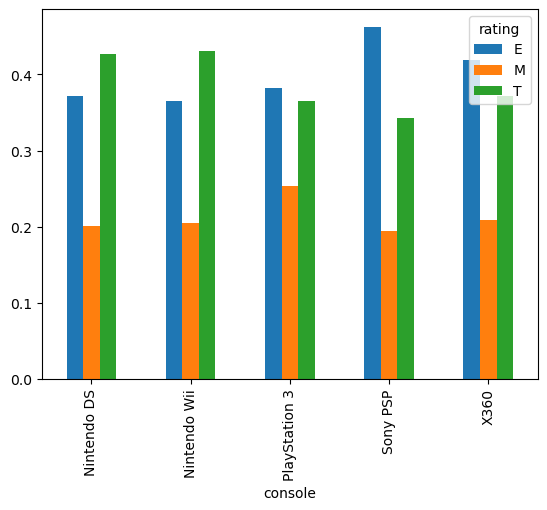

In [26]:
temp = pd.crosstab(games_final['console'], games_final['rating'], normalize='index')
temp.plot.bar()
plt.show()

As seen above, the same colored bars are of different heights, which indicates some association between `console` and `rating`, however, there does not seem to be a drastic change in the distributions for different `console` levels, so the association cannot be categorised as a strong one.

Finally, the association between the categorical and numerical variables will be examined.

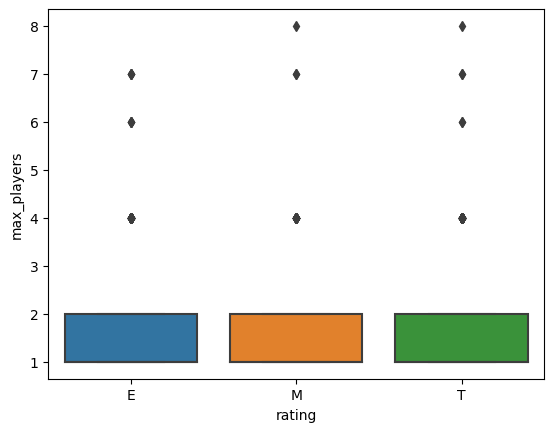

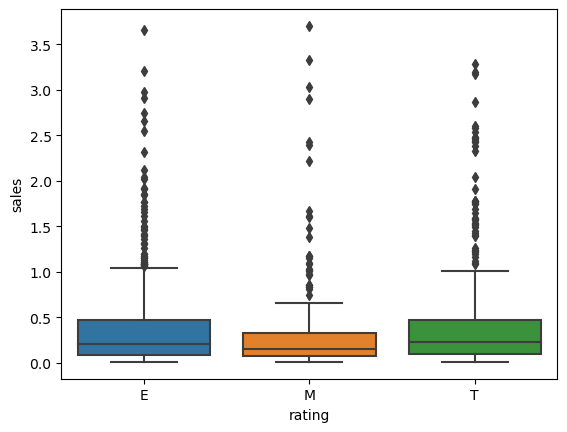

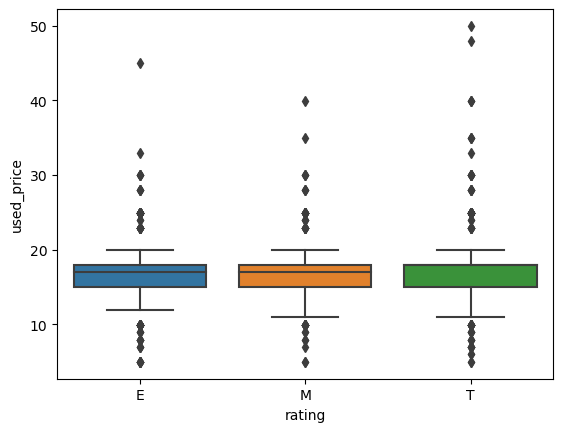

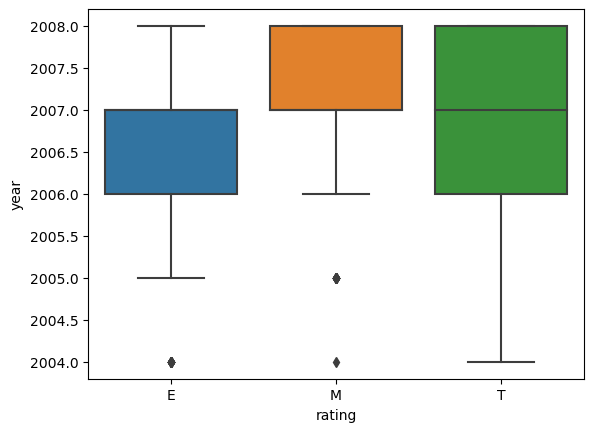

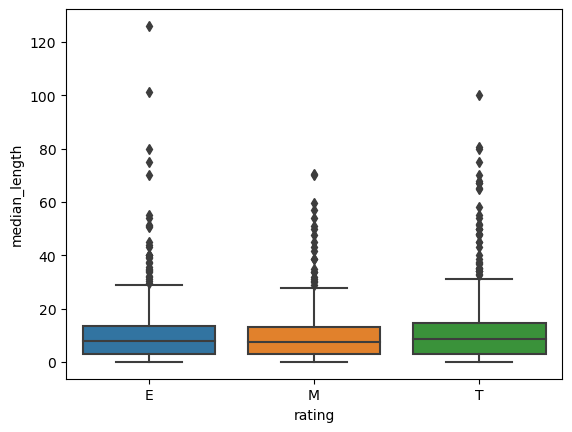

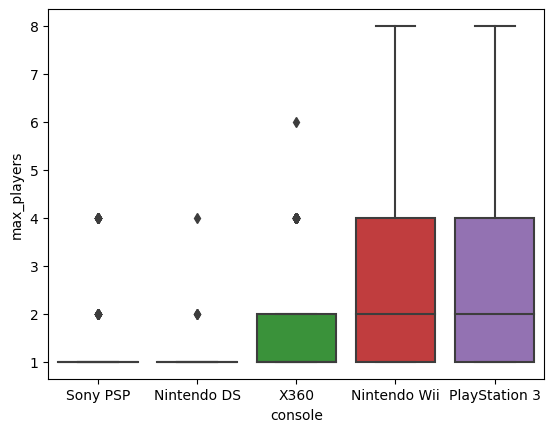

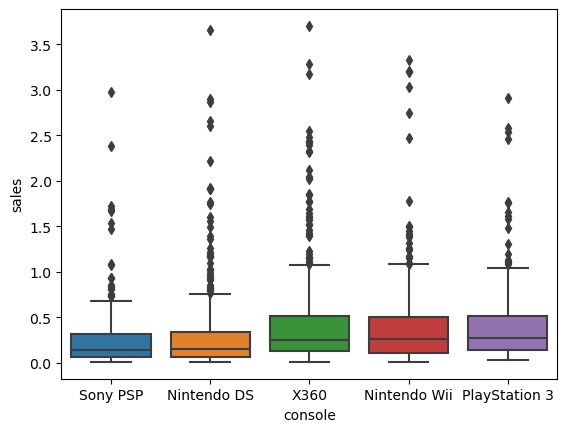

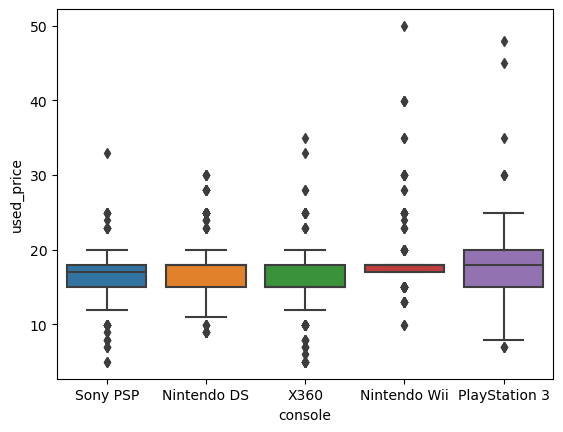

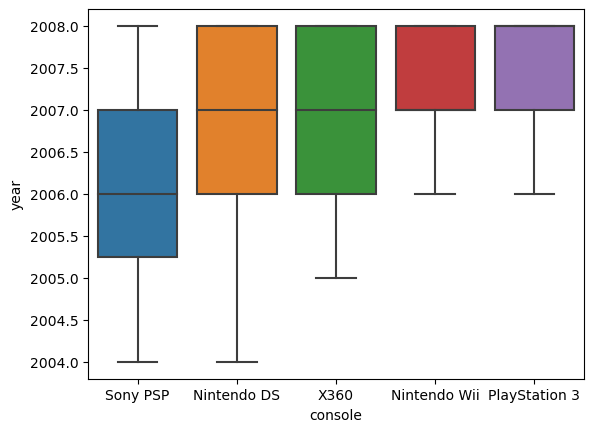

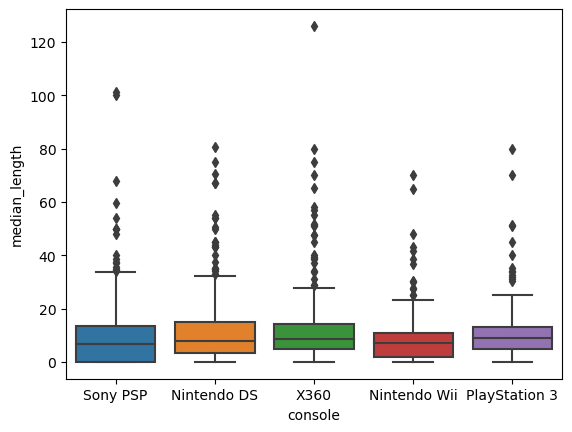

In [27]:
for i in cat:
    for j in num:
        sns.boxplot(x = i, y = j, data = games_final)
        plt.show()

From the graphs above, it seems that `year` and `console`, `year` and `rating`, and `max_players` and `console` have the strongest association, as evidenced by the boxes having not much overlap.

### 4.3 Interaction Effects

First off, the response must be converted into a 0/1 binary variable to check for interaction effects.

In [28]:
games_final['review_score_binary'] = games_final['review_score_binary'].replace({'High':1, 'Low':0})
games_final.head()

,max_players,sales,used_price,year,median_length,rating,console,review_score_binary
1,1,0.56,14.95,2004,10.0,E,Sony PSP,1
2,2,0.54,22.95,2004,2.5,E,Nintendo DS,1
3,1,0.49,12.95,2004,0.0,E,Sony PSP,1
4,1,0.45,14.95,2004,10.0,E,Nintendo DS,0
5,1,0.41,12.95,2004,20.0,M,Nintendo DS,0


Now that the response has been converted to a 0/1 binary variable, interaction effects can be tested for.

/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


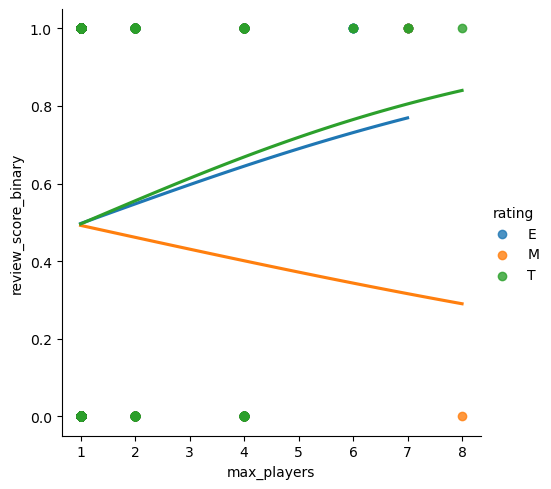

Optimization terminated successfully.
         Current function value: 0.684844
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2157,0.160,-1.348,0.178,-0.529,0.098
max_players,0.2028,0.082,2.467,0.014,0.042,0.364


Optimization terminated successfully.
         Current function value: 0.688920
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.0916,0.218,0.419,0.675,-0.336,0.520
max_players,-0.1234,0.109,-1.137,0.255,-0.336,0.089


Optimization terminated successfully.
         Current function value: 0.681376
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2562,0.163,-1.574,0.115,-0.575,0.063
max_players,0.2393,0.083,2.871,0.004,0.076,0.403


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


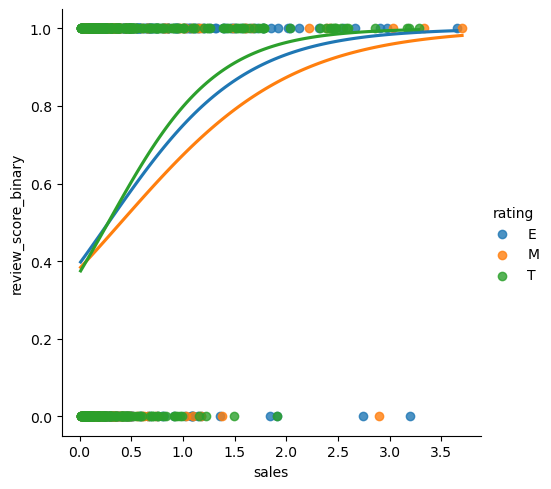

Optimization terminated successfully.
         Current function value: 0.646523
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.4299,0.129,-3.336,0.001,-0.682,-0.177
sales,1.5283,0.284,5.389,0.000,0.972,2.084


Optimization terminated successfully.
         Current function value: 0.661185
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.4844,0.166,-2.910,0.004,-0.811,-0.158
sales,1.2092,0.386,3.130,0.002,0.452,1.966


Optimization terminated successfully.
         Current function value: 0.629744
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5302,0.138,-3.854,0.000,-0.800,-0.261
sales,1.9055,0.334,5.701,0.000,1.250,2.561


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


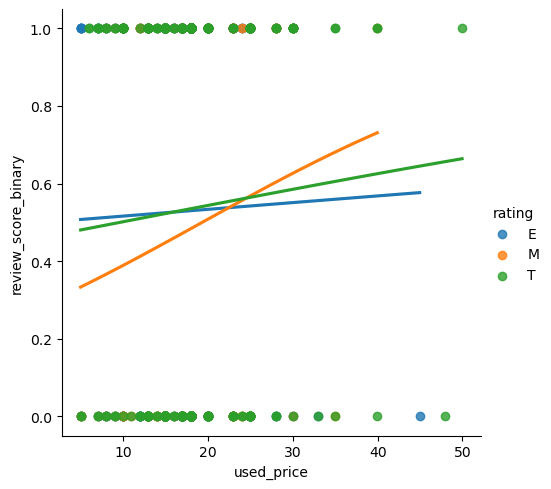

Optimization terminated successfully.
         Current function value: 0.691436
         Iterations 3


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0057,0.359,-0.016,0.987,-0.709,0.698
used_price,0.0070,0.020,0.342,0.733,-0.033,0.047


Optimization terminated successfully.
         Current function value: 0.685811
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.9343,0.508,-1.839,0.066,-1.930,0.062
used_price,0.0484,0.029,1.671,0.095,-0.008,0.105


Optimization terminated successfully.
         Current function value: 0.689952
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1627,0.331,-0.491,0.623,-0.811,0.486
used_price,0.0169,0.018,0.933,0.351,-0.019,0.052


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


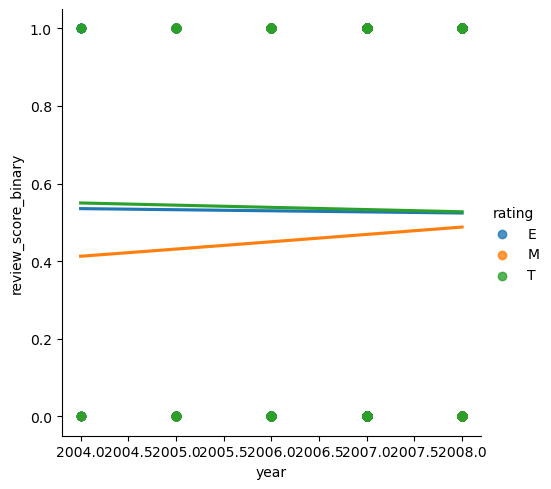

Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,22.8615,168.417,0.136,0.892,-307.230,352.953
year,-0.0113,0.084,-0.135,0.893,-0.176,0.153


Optimization terminated successfully.
         Current function value: 0.690951
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-153.0744,273.577,-0.560,0.576,-689.276,383.127
year,0.0762,0.136,0.559,0.576,-0.191,0.343


Optimization terminated successfully.
         Current function value: 0.690840
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,46.0123,188.467,0.244,0.807,-323.377,415.401
year,-0.0229,0.094,-0.243,0.808,-0.207,0.161


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


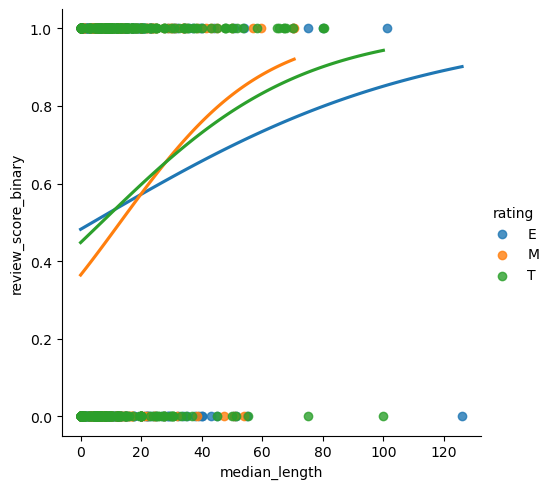

Optimization terminated successfully.
         Current function value: 0.685767
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0724,0.123,-0.591,0.555,-0.313,0.168
median_length,0.0181,0.008,2.212,0.027,0.002,0.034


Optimization terminated successfully.
         Current function value: 0.662954
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5579,0.179,-3.121,0.002,-0.908,-0.208
median_length,0.0427,0.012,3.419,0.001,0.018,0.067


Optimization terminated successfully.
         Current function value: 0.672425
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2100,0.127,-1.648,0.099,-0.460,0.040
median_length,0.0302,0.008,3.758,0.000,0.014,0.046


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


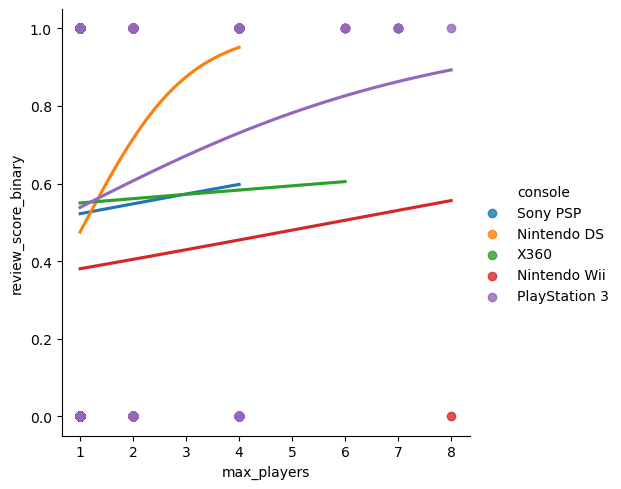

Optimization terminated successfully.
         Current function value: 0.690710
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0138,0.250,-0.055,0.956,-0.504,0.476
max_players,0.1025,0.170,0.604,0.546,-0.230,0.435


Optimization terminated successfully.
         Current function value: 0.689378
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.1221,1.005,-1.116,0.264,-3.093,0.848
max_players,1.0224,0.989,1.034,0.301,-0.916,2.961


Optimization terminated successfully.
         Current function value: 0.685499
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1548,0.228,0.680,0.496,-0.291,0.601
max_players,0.0452,0.100,0.451,0.652,-0.151,0.242


Optimization terminated successfully.
         Current function value: 0.674138
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5904,0.288,-2.052,0.040,-1.154,-0.026
max_players,0.1019,0.112,0.912,0.362,-0.117,0.321


Optimization terminated successfully.
         Current function value: 0.643135
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1273,0.270,-0.471,0.638,-0.657,0.403
max_players,0.2810,0.108,2.594,0.009,0.069,0.493


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


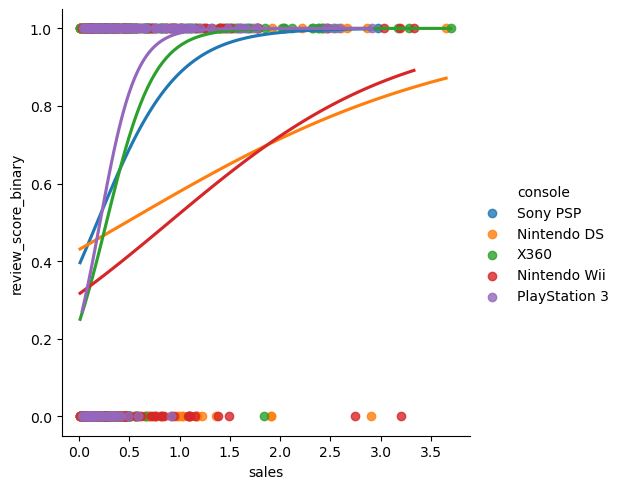

Optimization terminated successfully.
         Current function value: 0.645976
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.4466,0.187,-2.388,0.017,-0.813,-0.080
sales,2.4864,0.667,3.725,0.000,1.178,3.795


Optimization terminated successfully.
         Current function value: 0.682074
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2821,0.140,-2.012,0.044,-0.557,-0.007
sales,0.6023,0.256,2.349,0.019,0.100,1.105


Optimization terminated successfully.
         Current function value: 0.538123
         Iterations 8


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.1399,0.230,-4.946,0.000,-1.592,-0.688
sales,4.1911,0.739,5.671,0.000,2.743,5.640


Optimization terminated successfully.
         Current function value: 0.648857
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.7748,0.207,-3.752,0.000,-1.179,-0.370
sales,0.8659,0.307,2.823,0.005,0.265,1.467


Optimization terminated successfully.
         Current function value: 0.516927
         Iterations 8


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.1574,0.319,-3.632,0.000,-1.782,-0.533
sales,5.5686,1.149,4.848,0.000,3.317,7.820


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


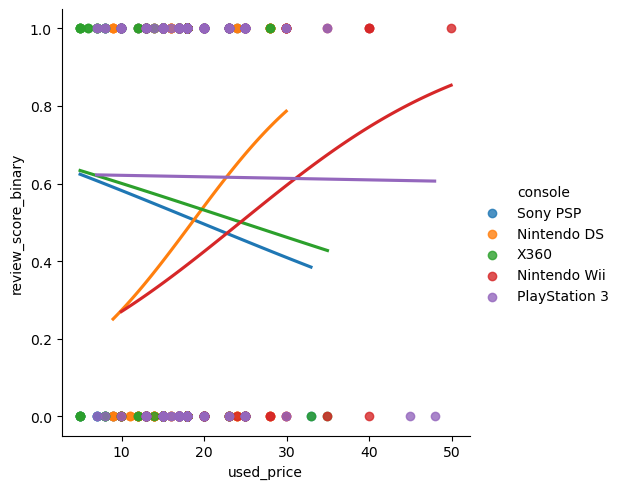

Optimization terminated successfully.
         Current function value: 0.689409
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.6787,0.581,1.168,0.243,-0.460,1.818
used_price,-0.0349,0.035,-0.994,0.320,-0.104,0.034


Optimization terminated successfully.
         Current function value: 0.664366
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.1185,0.525,-4.038,0.000,-3.147,-1.090
used_price,0.1143,0.029,3.962,0.000,0.058,0.171


Optimization terminated successfully.
         Current function value: 0.684021
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.6863,0.455,1.509,0.131,-0.205,1.578
used_price,-0.0280,0.028,-1.014,0.310,-0.082,0.026


Optimization terminated successfully.
         Current function value: 0.659182
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.6824,0.575,-2.927,0.003,-2.809,-0.556
used_price,0.0690,0.029,2.360,0.018,0.012,0.126


Optimization terminated successfully.
         Current function value: 0.665036
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.5108,0.527,0.970,0.332,-0.521,1.543
used_price,-0.0017,0.028,-0.059,0.953,-0.056,0.053


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


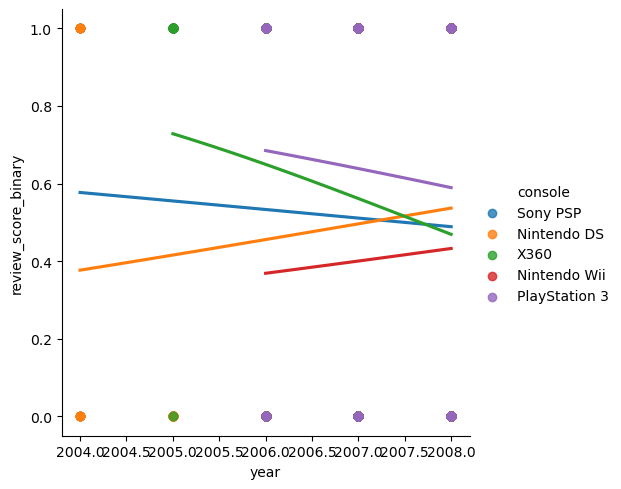

Optimization terminated successfully.
         Current function value: 0.690495
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,178.2861,259.351,0.687,0.492,-330.033,686.605
year,-0.0888,0.129,-0.687,0.492,-0.342,0.165


Optimization terminated successfully.
         Current function value: 0.687622
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-326.3698,193.709,-1.685,0.092,-706.032,53.292
year,0.1626,0.097,1.684,0.092,-0.027,0.352


Optimization terminated successfully.
         Current function value: 0.672061
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,742.9572,271.172,2.740,0.006,211.469,1274.446
year,-0.3701,0.135,-2.739,0.006,-0.635,-0.105


Optimization terminated successfully.
         Current function value: 0.675409
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-268.0959,440.700,-0.608,0.543,-1131.852,595.660
year,0.1334,0.220,0.608,0.544,-0.297,0.564


Optimization terminated successfully.
         Current function value: 0.662882
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,417.2725,477.985,0.873,0.383,-519.562,1354.107
year,-0.2076,0.238,-0.872,0.383,-0.674,0.259


/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


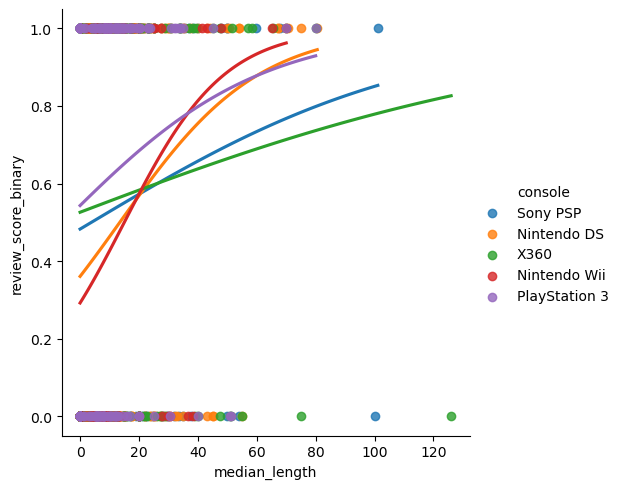

Optimization terminated successfully.
         Current function value: 0.684012
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0699,0.163,-0.428,0.668,-0.390,0.250
median_length,0.0181,0.010,1.795,0.073,-0.002,0.038


Optimization terminated successfully.
         Current function value: 0.660282
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5730,0.164,-3.487,0.000,-0.895,-0.251
median_length,0.0425,0.011,3.974,0.000,0.022,0.063


Optimization terminated successfully.
         Current function value: 0.682621
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1037,0.159,0.653,0.514,-0.208,0.415
median_length,0.0116,0.009,1.302,0.193,-0.006,0.029


Optimization terminated successfully.
         Current function value: 0.641433
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.8857,0.223,-3.970,0.000,-1.323,-0.448
median_length,0.0590,0.019,3.073,0.002,0.021,0.097


Optimization terminated successfully.
         Current function value: 0.654086
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1732,0.223,0.777,0.437,-0.264,0.610
median_length,0.0300,0.017,1.804,0.071,-0.003,0.063


In [29]:
for i in cat:
    for j in num: 
        sns.lmplot(x = j, y = 'review_score_binary', hue = i, data = games_final,
                  logistic = True, ci = False)
        plt.show()
        
        for k in games_final[i].unique():
            f = 'review_score_binary ~ ' + i + ' + ' + j
            log_mod = smf.logit(formula = str(f), data = games_final[games_final[i] == k]).fit()
            display(log_mod.summary().tables[1])

From the graphs and the model outputs it can be quickly noted that `console` and every numerical variable except `median_length` have an interaction in how they impact the response, as can be noted from the fact that the logistic regression slope for the respective numerical variable for the various levels of `console` are significantly different. Graphically, it can be seen that for these pairs, the horizontal stretch of the sigmoid curve is vastly different for the different categorical variable levels.

As for the categorical varible `rating` it seems only `max_players` has a significant interaction in how they impact the response, as seen by the vastly different slopes. All the other numerical variables do not have a significant interaction with `rating` in how they affect the response.

## 5. Model Data Preprocessing

### 5.1 0/1 Response Variable

The 0/1 response variable was created in the previous section while testing for interaction effects.

### 5.2 Features Matrix and Target Array

In [30]:
X = games_final.drop(['review_score_binary'], axis = 1)
Y = games_final['review_score_binary']

### 5.3 Explantory Variable Scaling

In [31]:
num = ['max_players', 'sales', 'used_price', 'year', 'median_length']
scaler = StandardScaler()
scaled_num = scaler.fit_transform(X[num])
num_scaled = pd.DataFrame(scaled_num, columns=num, index=X.index)
num_scaled.head()

,max_players,sales,used_price,year,median_length
1,-0.543608,0.311150,-0.472234,-2.695263,-0.083545
2,0.292496,0.273716,1.195009,-2.695263,-0.642791
3,-0.543608,0.180133,-0.889045,-2.695263,-0.829206
4,-0.543608,0.105266,-0.472234,-2.695263,-0.083545
5,-0.543608,0.030399,-0.889045,-2.695263,0.662116


In [32]:
X_scaled = pd.concat([num_scaled, X[['rating', 'console']]], axis=1)
X_scaled.head()

,max_players,sales,used_price,year,median_length,rating,console
1,-0.543608,0.311150,-0.472234,-2.695263,-0.083545,E,Sony PSP
2,0.292496,0.273716,1.195009,-2.695263,-0.642791,E,Nintendo DS
3,-0.543608,0.180133,-0.889045,-2.695263,-0.829206,E,Sony PSP
4,-0.543608,0.105266,-0.472234,-2.695263,-0.083545,E,Nintendo DS
5,-0.543608,0.030399,-0.889045,-2.695263,0.662116,M,Nintendo DS


### 5.4 Indicator Variables

In [33]:
X_dummy = pd.get_dummies(X_scaled, drop_first=True, dtype=int)
X_final = X_dummy.rename(columns={'console_Nintendo Wii':'console_Nintendo_Wii',
                                  'console_PlayStation 3':'console_PlayStation_3',
                                  'console_Sony PSP':'console_Sony_PSP'})
X_final.head()

,max_players,sales,used_price,year,median_length,rating_M,rating_T,console_Nintendo_Wii,console_PlayStation_3,console_Sony_PSP,console_X360
1,-0.543608,0.311150,-0.472234,-2.695263,-0.083545,0,0,0,0,1,0
2,0.292496,0.273716,1.195009,-2.695263,-0.642791,0,0,0,0,0,0
3,-0.543608,0.180133,-0.889045,-2.695263,-0.829206,0,0,0,0,1,0
4,-0.543608,0.105266,-0.472234,-2.695263,-0.083545,0,0,0,0,0,0
5,-0.543608,0.030399,-0.889045,-2.695263,0.662116,1,0,0,0,0,0


## 6. Feature Selection with k-Fold Cross-Validation

This study will perform a backwards elimination algorithm that tries to select the logistic regression model with the highest average test AUC in the k=5 fold cross-validation.

In [34]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=100)

In [35]:
log_mod = LogisticRegression()

In [36]:
fold_roc = cross_val_score(log_mod, X_final, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6891592408344727


In [37]:
X_play = X_final[['sales', 'used_price', 'year', 'median_length',
       'rating_M', 'rating_T', 'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6848556378492165


In [38]:
X_sale = X_final[['max_players', 'used_price', 'year', 'median_length',
       'rating_M', 'rating_T', 'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6130788147938874


In [39]:
X_price = X_final[['max_players', 'sales', 'year', 'median_length',
       'rating_M', 'rating_T', 'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_price, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6922161292140385


In [40]:
X_year = X_final[['max_players', 'sales', 'used_price', 'median_length',
       'rating_M', 'rating_T', 'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_year, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6902700988504973


In [41]:
X_len = X_final[['max_players', 'sales', 'used_price', 'year',
       'rating_M', 'rating_T', 'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6691404160948455


In [42]:
X_rating = X_final[['max_players', 'sales', 'used_price', 'year', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6942602179641453


In [43]:
X_con = X_final[['max_players', 'sales', 'used_price', 'year', 'median_length',
       'rating_M', 'rating_T']]

fold_roc = cross_val_score(log_mod, X_con, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6927565847137535


The model without `rating` has the highest mean test fold AUC, so this is set as the full model for the next iteration.

In [44]:
X_rating = X_final[['max_players', 'sales', 'used_price', 'year', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6942602179641453


In [45]:
X_rating_play = X_final[['sales', 'used_price', 'year', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6911413471781788


In [46]:
X_rating_sale = X_final[['max_players', 'used_price', 'year', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.616973346688801


In [47]:
X_rating_price = X_final[['max_players', 'sales', 'year', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating_price, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6971641097386122


In [48]:
X_rating_year = X_final[['max_players', 'sales', 'used_price', 'median_length',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating_year, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6952507182929744


In [49]:
X_rating_len = X_final[['max_players', 'sales', 'used_price', 'year',
       'console_Nintendo_Wii', 'console_PlayStation_3',
       'console_Sony_PSP', 'console_X360']]

fold_roc = cross_val_score(log_mod, X_rating_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6747667945842316


In [50]:
X_rating_con = X_final[['max_players', 'sales', 'used_price', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6986023234938658


The model without `rating` and `console` has the highest mean test fold AUC, so this is set as the full model for the next iteration.

In [51]:
X_rating_con = X_final[['max_players', 'sales', 'used_price', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6986023234938658


In [52]:
X_rating_con_play = X_final[[ 'sales', 'used_price', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6976666992022799


In [53]:
X_rating_con_sale = X_final[['max_players', 'used_price', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6184543003613153


In [54]:
X_rating_con_price = X_final[['max_players', 'sales', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7026563466001974


In [55]:
X_rating_con_year = X_final[['max_players', 'sales', 'used_price', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_year, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6988207782192994


In [56]:
X_rating_con_len = X_final[['max_players', 'sales', 'used_price', 'year']]

fold_roc = cross_val_score(log_mod, X_rating_con_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6725850753258337


The model without `rating`, `console`, and `used_price` has the highest mean test fold AUC, so this is set as the full model for the next iteration.

In [57]:
X_rating_con_price = X_final[['max_players', 'sales', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7026563466001974


In [58]:
X_rating_con_price_play = X_final[['sales', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7015662293388287


In [59]:
X_rating_con_price_sale = X_final[['max_players', 'year', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6280763336388113


In [60]:
X_rating_con_price_yr = X_final[['max_players', 'sales', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7040732146928047


In [61]:
X_rating_con_price_len = X_final[['max_players', 'sales', 'year']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6779989176805316


The model without `rating`, `console`, `used_price`, and `year` has the highest mean test fold AUC, so this is set as the full model for the next iteration.

In [62]:
X_rating_con_price_yr = X_final[['max_players', 'sales', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7040732146928047


In [63]:
X_rating_con_price_yr_play = X_final[['sales', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7041756870730592


In [64]:
X_rating_con_price_yr_sale = X_final[['max_players', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6361150021699026


In [65]:
X_rating_con_price_yr_len = X_final[['max_players', 'sales']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6839850992307185


The model without `rating`, `console`, `used_price`, `year`, and `max_players` has the highest mean test fold AUC, so this is set as the full model for the next iteration.

In [66]:
X_rating_con_price_yr_play = X_final[['sales', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_play, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.7041756870730592


In [67]:
X_rating_con_price_yr_play_sale = X_final[['median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_play_sale, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6338897853605033


In [68]:
X_rating_con_price_yr_play_len = X_final[['sales']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_play_len, Y, cv=cross_val, scoring='roc_auc')
print('Mean Test Fold AUC:', fold_roc.mean())

Mean Test Fold AUC: 0.6900718036601032


The full model for this iteration still has the highest mean test fold AUC, so the algorithm is terminated and this model is selected as the best model by backwards elimination.

## 7. Best Model Discussion

The AUC statistics of the final model selected by backwards elimination is shown below.

In [69]:
final_mod = X_final[['sales', 'median_length']]

fold_roc = cross_val_score(log_mod, X_rating_con_price_yr_play, Y, cv=cross_val, scoring='roc_auc')
print('Test Fold AUC Values:', fold_roc)
print('Mean Test Fold AUC:', fold_roc.mean())
print('Std Test Fold AUC:', fold_roc.std())

Test Fold AUC Values: [0.74004208 0.72269417 0.66302889 0.69574889 0.69936441]
Mean Test Fold AUC: 0.7041756870730592
Std Test Fold AUC: 0.026140200728445796


### 7.1 Train-Test Split

To create the training and test dataset, the unscaled dataset should be used, because the features matrix created before will have a different scaling as it uses the entire dataset.

In [70]:
games_train, games_test = train_test_split(games_final[['review_score_binary', 'sales', 'median_length']],
                                           test_size=0.2, random_state=101)

### 7.2 Fit the Chosen Model

Before fitting the model, the new scaled features matrices for the training and test dataset must be created.

In [71]:
X_train = games_train.drop(['review_score_binary'], axis = 1).reset_index(drop=True)
Y_train = games_train['review_score_binary'].reset_index(drop=True)

X_test = games_test.drop(['review_score_binary'], axis = 1).reset_index(drop=True)
Y_test = games_test['review_score_binary'].reset_index(drop=True)

Now, a `StandardScaler` object can be instantiated, and the two datasets can be scaled (on the training datasets scale).

In [72]:
scaler_train = StandardScaler()

scaled_train = scaler_train.fit_transform(X_train)
X_scaled_train = pd.DataFrame(scaled_train, columns=X_train.columns)
X_scaled_train.head()

,sales,median_length
0,-0.063459,-0.829988
1,-0.026639,1.161992
2,0.047000,-0.534879
3,-0.523706,-0.482006
4,4.170817,0.645553


In [73]:
scaled_test = scaler_train.transform(X_test)
X_scaled_test = pd.DataFrame(scaled_test, columns=X_test.columns)
X_scaled_test.head()

,sales,median_length
0,0.838626,0.645553
1,-0.597346,-0.350437
2,0.562477,-0.829988
3,-0.302788,-0.829988
4,0.175870,-0.829988


Finally, the model can be fit.

In [74]:
log_mod.fit(X_scaled_train, Y_train)

LogisticRegression()

### 7.3 Equation

In [75]:
df_slopes = pd.DataFrame(log_mod.coef_.T, columns=['log_mod'], index=X_scaled_train.columns)

print('Model Intercept: ', log_mod.intercept_)

print('\nModel Slopes: ')
df_slopes

Model Intercept:  [0.17057146]

Model Slopes: 


,log_mod
sales,0.783713
median_length,0.237943


Now, the equation of the best logistic regression equation selected by backwards elimination can be written using the slope and intercept values obtained above.

The probability the game has a high review score is given by:

$$
\begin{align}
\hat{\mathrm{p}} = \frac{1}{1 + \exp \left(\begin{matrix}
& - 0.17057146 \\ 
-& 0.783713 \times \mathrm{sales} \\
& 0.237943 \times \mathrm{median\_length} \\
\end{matrix}\right)}
\end{align}
$$

### 7.4 Multicollinearity

The only two explanatory variables in the final model are `sales` and `median_length`. To check for multicollinearity, their correlation coefficient and scatterplot will be inspected.

/Users/vedaant/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


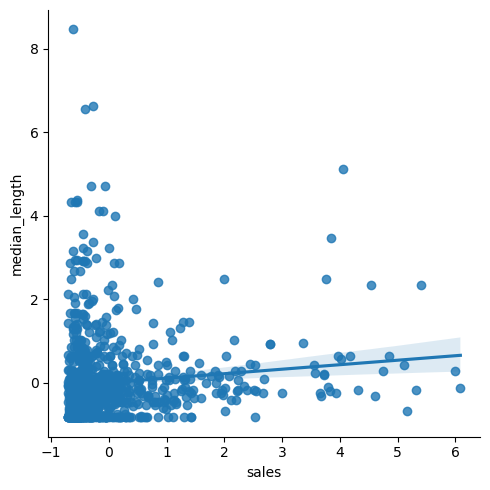

In [76]:
sns.lmplot(x='sales', y='median_length', data=X_scaled_train)
plt.show()

In [77]:
X_scaled_train.corr()

,sales,median_length
sales,1.00000,0.10776
median_length,0.10776,1.00000


As seen by the correlation coefficient value, the chosen model should not suffer from multicollinearity.

### 7.5 Slope Interpretations

Because the final model does not suffer from multicollinearity, and the final model uses scaled variables, one can interpret the magnitudes of the slopes as indicating how important the corresponding explanatory variable is when it comes to predicting the response variable in a logistic regression model. 

`sales` is the most important explanatory variable in predicting the response for this model, as evidenced by it having the largest absolute value of the slopes in the logistic regression model.

### 7.6 Overfitting Explanatory Variables

The "best model" suggests `max_players`, `used_price`, `year`, `rating`, and `console` were overfitting the model.

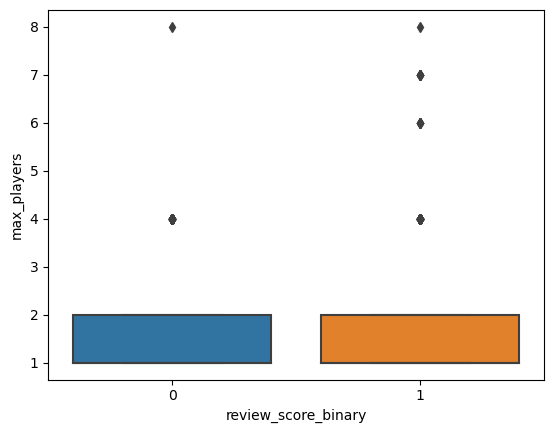

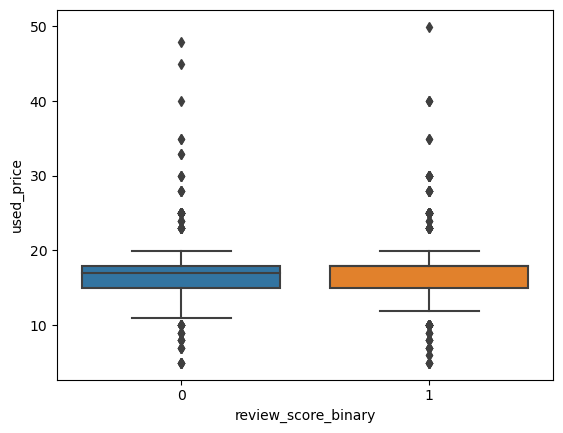

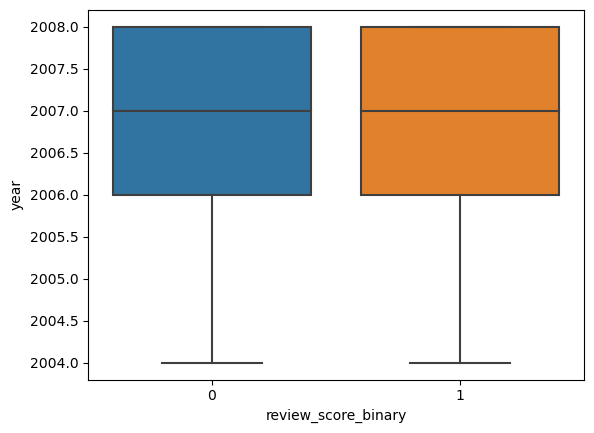

In [78]:
num2 = ['max_players', 'used_price', 'year']

for i in num2:
    sns.boxplot(x = 'review_score_binary', y = i, data = games_final)
    plt.show()

As seen in the boxplots above, the three numerical variables dropped by the final model have the exact same distribution (barring outliers) for the two levels of the response. This indicates that these numerical variables have no associaton with the response, so the final model dropping them makes sense. 

Next, the relation of the dropped categorical variables with the response will be looked at.

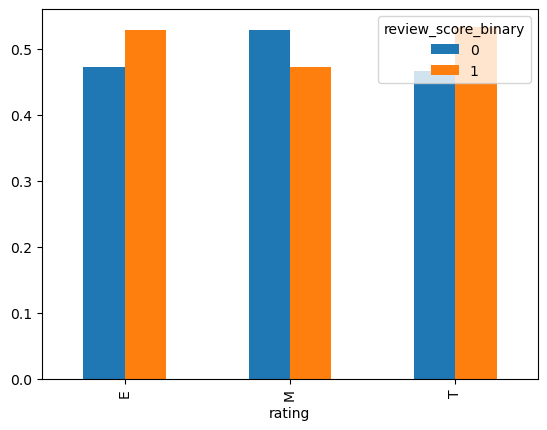

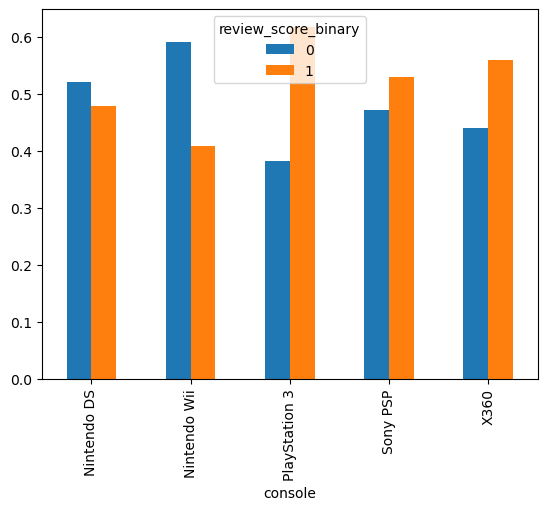

In [79]:
cat = ['rating', 'console']
for i in cat:
    temp = pd.crosstab(games_final[i], games_final['review_score_binary'], normalize='index')
    temp.plot.bar()
    plt.show()

As seen in the barplots above, both categorical variables have some assocation with the response, but `console` has a much stronger association (comparatively). However, the strength of both of these aassociations are still fairly low. 

Next, the relation of the dropped categorical variables with those still in the final model should be checked. Checking for the relation of the dropped numerical variable is redundant since it was noted that these variables have no association with the response.

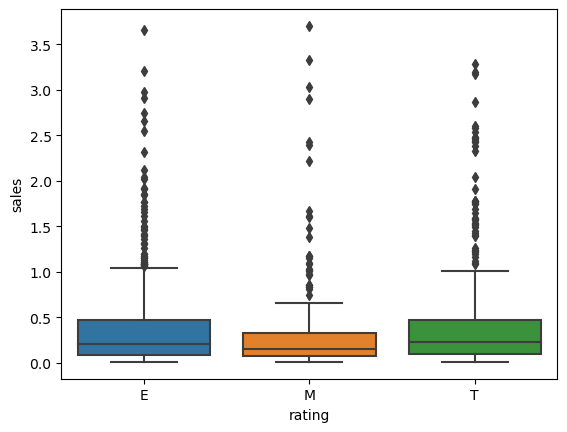

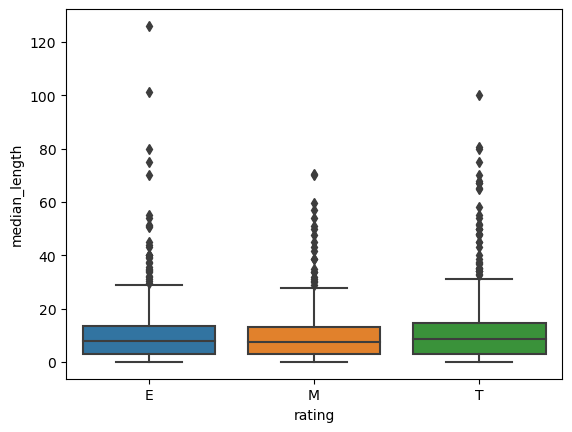

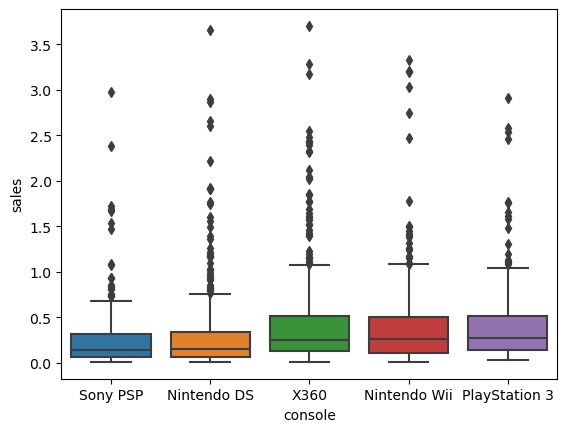

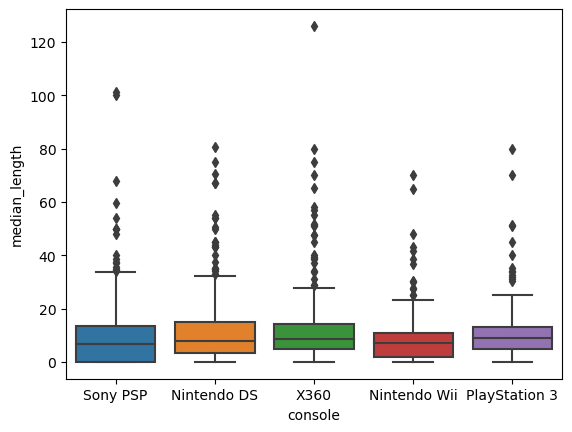

In [80]:
num3 = ['sales', 'median_length']

for i in cat:
    for j in num3:
        sns.boxplot(x = i, y = j, data = games_final)
        plt.show()

There does not seem to be a strong association between any pair of these variables, which might indicate that the reason the categorical variables were dropped from the final model is that they did not have a strong enough relation with the response to justify their inclusion.

### 7.7 Test ROC and AUC

In [81]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
             label = 'ROC curve (area = '+ str(round(auc, 3)) + ')')
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [82]:
pred_prob_test = log_mod.predict_proba(X_scaled_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_true=Y_test, y_score=pred_prob_test)

auc = roc_auc_score(y_true=Y_test, y_score=pred_prob_test)
auc

0.740861344537815

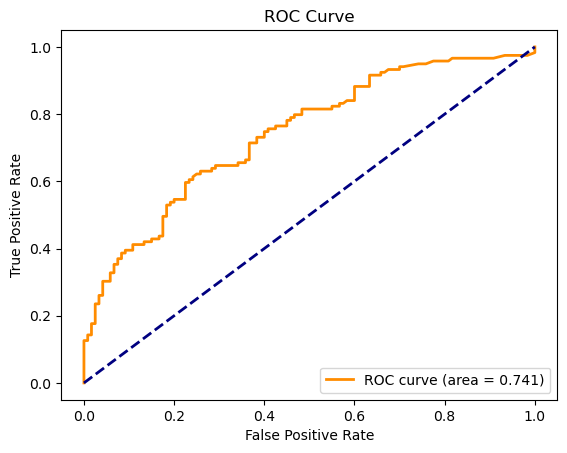

In [83]:
plot_roc(fprs, tprs, auc)

It can be noted from the graph that the top left corner is moderately far away from the orange line, indicating that a classifier with near perfect accuracy is not possible. The test AUC is also 0.741, which is not terrible, but is also not the best, so this logistic regression model might misclassify a fair chunk of observations. 

### 7.8 Best Predictive Probability Threshold

In [84]:
def fpr_tpr_thresh(y, pred_prob, thresh):
    yhat = 1*(pred_prob >= thresh)
    tn, fp, fn, tp = confusion_matrix(y_true = y, y_pred=yhat).ravel()
    tpr = tp/(fn + tp)
    fpr = fp/(fp + tn)
    return pd.DataFrame({'threshold':[thresh],
                        'fpr':[fpr],
                        'tpr': [tpr]})

In [85]:
for thresh in np.arange(0.1, 1.01, 0.01):
    print(fpr_tpr_thresh(Y_test,
                        pred_prob_test,
                        thresh))

   threshold  fpr  tpr
0        0.1  1.0  1.0
   threshold  fpr  tpr
0       0.11  1.0  1.0
   threshold  fpr  tpr
0       0.12  1.0  1.0
   threshold  fpr  tpr
0       0.13  1.0  1.0
   threshold  fpr  tpr
0       0.14  1.0  1.0
   threshold  fpr  tpr
0       0.15  1.0  1.0
   threshold  fpr  tpr
0       0.16  1.0  1.0
   threshold  fpr  tpr
0       0.17  1.0  1.0
   threshold  fpr  tpr
0       0.18  1.0  1.0
   threshold  fpr  tpr
0       0.19  1.0  1.0
   threshold  fpr  tpr
0        0.2  1.0  1.0
   threshold  fpr  tpr
0       0.21  1.0  1.0
   threshold  fpr  tpr
0       0.22  1.0  1.0
   threshold  fpr  tpr
0       0.23  1.0  1.0
   threshold  fpr  tpr
0       0.24  1.0  1.0
   threshold  fpr  tpr
0       0.25  1.0  1.0
   threshold  fpr  tpr
0       0.26  1.0  1.0
   threshold  fpr  tpr
0       0.27  1.0  1.0
   threshold  fpr  tpr
0       0.28  1.0  1.0
   threshold  fpr  tpr
0       0.29  1.0  1.0
   threshold  fpr  tpr
0        0.3  1.0  1.0
   threshold  fpr  tpr
0       0.3

Given that the primary goal of the classifier was to get high accuracy on both, a threshold which balances this compromise has to be selected. Looking at the values, the best threshold value to meet this expectations seems to be 0.5; and at this classification threshold, the values of the FPR and TPR are:

1. Test TPR: 0.621849
2. Test FPR: 0.25

The TPR for a threshold value of 0.5 implies that in the test dataset about 62.18% of the games with a high review score are accurately classified as a game with a high review score.

The FPR for a threshold value of 0.5 implies that in the test dataset about 25% of the games with a low review score are inaccurately classified as a game with a high review score.

## 8. Additional Analysis/Insight

We want to perform K-Means clustering with 2 clusters on the final model to see how well the final model accurately recognises whether the review score is high or low.

In [86]:
cluster = KMeans(2, random_state = 100)

In [87]:
cluster = cluster.fit(X_final[['sales', 'median_length']])

/Users/vedaant/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [88]:
vals = cluster.predict(X_final[['sales', 'median_length']])

In [89]:
games_final['cluster'] = vals
games_final[['review_score_binary', 'cluster']]

,review_score_binary,cluster
1,1,0
2,1,0
3,1,0
4,0,0
5,0,0
...,...,...
1207,1,0
1208,0,0
1209,0,0
1210,0,0


It seems the cluster has designated 1 to be the high review score and 0 to be the low review score. Taking a look at how many mismatches there are:

In [90]:
mismatch = 0

for i in range(len(vals)):
    if vals[i] != Y.values[i]:
        mismatch += 1

mismatch

515

In [91]:
mismatch/len(vals)

0.4320469798657718

So, according to K-Means clustering with 2 clusters, about 43.2% of the total observations are incorrectly classified. This might hint that the final model selected is not the best.

## 9. Conclusion

In conclusion, the model chosen by Backwards elimination only selected `sales` and `median_length` as predictors, and dropped all other variables. Also, both these variables had a positive logistic slope, and their interpretability was well established so it can be said that higher gross sales and higher median length of game completion would expect to have a game with a higher review score. Thus, game publishers might want to make longer games, and rating companies like IGN might want to take a look at game revenue to provide them with a baseline review score.

That being said, the final model presented in this study would not be recommended. While review score classification is something that is not expected to be extremely accurate, big game production companies might not want to take a chance with betting on a classifier with a TPR of only about 62%, while also misclassifying some games with a low review score, and also having a fairly mediocre test AUC of 0.741. However, what game companies might benefit from looking at this study is realising which variables did not have an effect on the review score.

Of course, these variables are only selected by Backwards elimination, which does not guarantee selecting the best possible model. For a more complete analysis, regularization might have been employed as another technique to search for the best test AUC performance. Moreover, interaction terms could also have been included in the models for a more thorough study, and more careful inspection of the outliers and outlier removal methods could be done.

For future work, to build onto this study, one idea would be to perhaps incorporate and scrape more game data about newer games to add to the dataset and redo the analysis to see if newer games deviate significantly from past trends. Apart from that, as mentioned before, future studies might try incorporating interaction terms to try and find a better model.

## References

1. "What makes a blockbuster video game? an empirical analysis of US sales data", Joe Cox (https://researchportal.port.ac.uk/en/publications/what-makes-a-blockbuster-video-game-an-empirical-analysis-of-us-s)


2. "Video Game Sales Analysis", Lehak Narnauli (https://datascience.fm/video-game-sales-analysis/)